# Week 9 - Multivariate Analysis, part 2

# 1. Lesson - no lesson this week

# 2. Weekly graph question

The graph below plots the first two principal component scores in a scatter plot.  

- What can be said about the three outliers in the upper left corner of the graph?  
- Is their first principal component score high or low?  
- What about their second principal component score?  
- What does that mean about their values in series_1, series_2, and series_3?  

- It seems to me that you can say something about series_3 (what can you say?) but you may have a harder time saying something about series_1 and series_2, and an almost impossible time saying anything about the relative values of series_1 and series_2.  Why is that?  

- How are series_1 and series_2 related, according to how they were created?  If you like, try drawing a pairplot for all three series and see what you get.

Overall, what are the advantages and disadvantages of the graph below?  Does it show anything interesting?

[0.79916477 0.18990532 0.01092991]
[[ 0.26541493  0.30096233  0.91595665]
 [ 0.60337553  0.6891417  -0.40127506]
 [ 0.75199261 -0.65917023 -0.00131519]]


Text(0, 0.5, 'Second Principal Component Score')

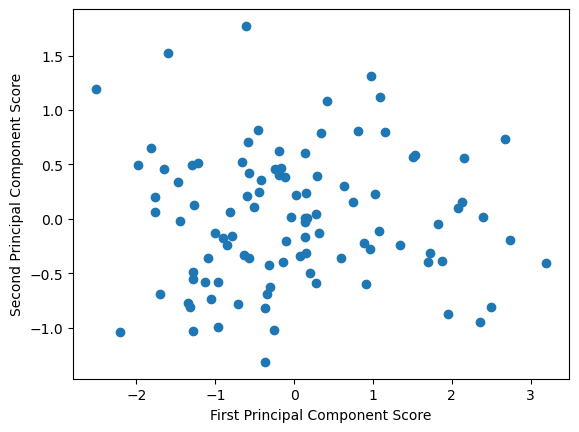

In [1]:
import numpy as np
import pandas as pd
from sklearn import decomposition
import matplotlib.pyplot as plt

np.random.seed(0)
num_points = 100
series_1 = np.random.normal(loc = 2, scale = 0.5, size = num_points)
series_2 = series_1 * (1 + np.random.normal(loc = 0, scale = 0.1, size = num_points))
series_3 = series_1 * (1 + np.random.normal(loc = 0, scale = 0.5, size = num_points))
df = pd.DataFrame({'ser1': series_1, 'ser2': series_2, 'ser3': series_3})
df = df - df.mean() # set mean to zero, so we don't have to subtract mean from the principal component scores

pca3 = decomposition.PCA(n_components = 3)
pca3.fit(df)
print(pca3.explained_variance_ratio_)
print(pca3.components_)

first_principal_component_score = df.dot(pca3.components_[0])
second_principal_component_score = df.dot(pca3.components_[1])
plt.scatter(first_principal_component_score, second_principal_component_score)
plt.xlabel("First Principal Component Score")
plt.ylabel("Second Principal Component Score")

- **Q:** What can be said about the three outliers in the upper left corner of the graph? Is their first principal component score high or low? 
- **A:** These outliers have Low First Principal Component values (-1 to -2).

- **Q:** What about their second principal component score?
- **A:** These outliers have a high second principal component values (>1 or higher)
   
- **Q:** What does that mean about their values in `series_1`, `series_2`, and `series_3`?
- **A:** PC1 is heavily influenced by `series_1` (0.7991). The outliers low PC1 score suggest their values in `series_1` are low. PC2 is mostly influenced by `series_3`  The outliers' high PC2 score implies lower values in `series_3`.

- **Q:** It seems to me that you can say something about `series_3` (what can you say?) but you may have a harder time saying something about `series_1` and `series_2`, and an almost impossible time saying anything about the relative values of `series_1` and `series_2`.  Why is that?
- **A:** Since the components are linear combinations of the original features, the components are orthogonal/uncorrelated, but not easy to translate back into simple "larger than" comparisons unless we reconstruct the PCA-inverse.

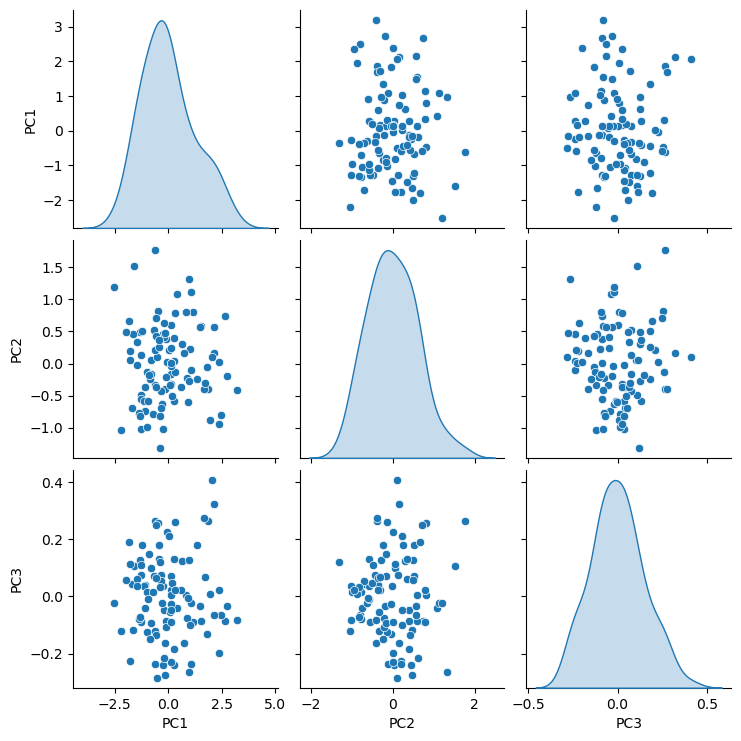

In [2]:
#make a dataframe of the principal component scores
pca_scores = pca3.transform(df)
pca_df = pd.DataFrame(pca_scores, columns = ['PC1', 'PC2', 'PC3'])

#make the pairplot
import seaborn as sns
sns.pairplot(pca_df, diag_kind = 'kde')
plt.show()

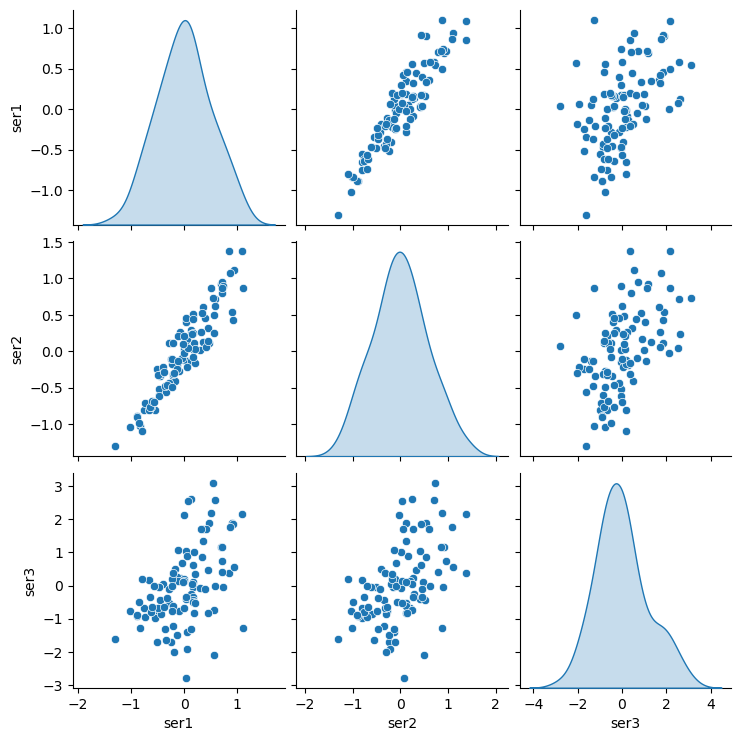

In [3]:
sns.pairplot(df, diag_kind = 'kde')
plt.show()

- **Q:** How are series_1 and series_2 related, according to how they were created?  If you like, try drawing a pairplot for all three series and see what you get.
- **A:** From the pairplot of the pca (and the original dataframe) we can see that `series_1` and `series_2` are highly positively correlated.

- **Q:** Overall, what are the advantages and disadvantages of the graph below?  Does it show anything interesting?
    - **Advantages:**
        - Reduces 3D data into 2D while preserving most variance.
        - Helps reveal clusters or outliers (like the upper-left group).
        - Shows how the data varies along major directions of variation (PCA axes).
    - **Disadvantages:**
        - Interpretability: Hard to directly link back to original features without looking at component loadings.
        - You lose fine-grained info about individual features (e.g., exact values in series_1, etc.).
        - Outliers in PCA space may not always be outliers in original feature space.

# 3. Working on your datasets

This week, you will do the same types of exercises as last week, but you should use your chosen datasets that someone in your class found last semester. (They likely will not be the particular datasets that you found yourself.)

Here are some types of analysis you can do:
Draw heatmaps.

Draw bubble plots.

Perform Principal Component Analysis to find out the directions in which the data varies.  Can you represent the data using only its projection onto its first principal component, using the methods described in Week 8?  How much of the variance would this capture?

Try performing linear regression analysis using different sets of features.  Which features seem most likely to be useful to predict other features?

Conclusions:
Explain what conclusions you would draw from this analysis: are the data what you expect? Are the data likely to be usable? If the data are not useable, find some new data!

Do you see any outliers? (Data points that are far from the rest of the data).

Does the Principal Component Analysis suggest a way to represent the data using fewer dimensions than usual - using its first one or two principal component scores, perhaps?

Try using your correlation information from previous weeks to help choose features for linear regression.

# Dataset 1

In [4]:
# dataset 1
play_df = pd.read_csv('datasets/nfl-playing-surface-analytics/PlayList.csv')
player_df = pd.read_csv('datasets/nfl-playing-surface-analytics/PlayerTrackData.csv')
injury_df = pd.read_csv('datasets/nfl-playing-surface-analytics/InjuryRecord.csv')


# --- Create Initial Game DataFrame ---
game_df = play_df[['GameID', 'StadiumType', 'FieldType', 'Weather', 'Temperature']]
game_df = game_df.drop_duplicates()
game_df = game_df.reset_index(drop=True)

# --- Define Vectorized Cleaning Functions ---

def clean_weather_vectorized(df):
    """
    Clean the 'Weather' column using vectorized operations.
    Maps raw weather strings to standard categories and sets special conditions to None.
    """
    # Define condition sets (as Python sets for fast membership checking)
    cloudy_conditions = {
        'Cloudy 50% change of rain', 'Hazy', 'Cloudy.', 'Overcast', 'Mostly Cloudy',
        'Cloudy, fog started developing in 2nd quarter', 'Partly Cloudy',
        'Mostly cloudy', 'Rain Chance 40%', ' Partly cloudy', 'Party Cloudy',
        'Rain likely, temps in low 40s', 'Partly Clouidy', 'Cloudy, 50% change of rain',
        'Mostly Coudy', '10% Chance of Rain', 'Cloudy, chance of rain', 
        '30% Chance of Rain', 'Cloudy, light snow accumulating 1-3"', 'cloudy', 
        'Coudy', 'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
        'Cloudy fog started developing in 2nd quarter', 'Cloudy light snow accumulating 1-3"',
        'Cloudywith periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
        'Cloudy and cold', 'Cloudy and Cool', 'Partly cloudy'
    }
    clear_conditions = {
        'Clear, Windy', 'Clear to Cloudy', 'Clear, highs to upper 80s', 'Clear and clear',
        'Partly sunny', 'Clear skies', 'Sunny', 'Partly Sunny', 'Mostly Sunny',
        'Clear Skies', 'Sunny Skies', 'Partly clear', 'Fair', 'Sunny, highs to upper 80s',
        'Sun & clouds', 'Mostly sunny', 'Sunny, Windy', 'Mostly Sunny Skies',
        'Clear and Sunny', 'Clear and sunny', 'Clear to Partly Cloudy', 'Clear Skies',
        'Clear and cold', 'Clear and warm', 'Clear and Cool', 'Sunny and cold',
        'Sunny and warm', 'Sunny and clear'
    }
    rainy_conditions = {
        'Rainy', 'Scattered Showers', 'Showers', 'Cloudy Rain', 'Light Rain', 
        'Rain shower', 'Rain likely, temps in low 40s.', 'Cloudy, Rain'
    }
    snow_conditions = {'Heavy lake effect snow'}
    indoor_conditions = {'Controlled Climate', 'Indoors', 'N/A Indoor', 'N/A (Indoors)'}
    
    # Perform vectorized conditional replacements on the Weather column
    df['Weather'] = df['Weather']\
        .mask(df['Weather'].isin(cloudy_conditions), 'Cloudy')\
        .mask(df['Weather'].isin(indoor_conditions), 'Indoor')\
        .mask(df['Weather'].isin(clear_conditions), 'Clear')\
        .mask(df['Weather'].isin(rainy_conditions), 'Rain')\
        .mask(df['Weather'].isin(snow_conditions), 'Snow')\
        .mask(df['Weather'].isin(['Cloudy.', 'Heat Index 95', 'Cold']), None)
    return df

def clean_stadiumtype_vectorized(df):
    """
    Clean the 'StadiumType' column using regex replacements and vectorized anomaly filtering.
    """
    # Standardize common StadiumType misspellings/formats using regex
    df['StadiumType'] = df['StadiumType'].str.replace(
        r'Oudoor|Outdoors|Ourdoor|Outddors|Outdor|Outside', 'Outdoor', regex=True
    )
    df['StadiumType'] = df['StadiumType'].str.replace(
        r'Indoors|Indoor, Roof Closed|Indoor, Open Roof', 'Indoor', regex=True
    )
    df['StadiumType'] = df['StadiumType'].str.replace(
        r'Closed Dome|Domed, closed|Domed, Open|Domed, open|Dome, closed|Domed', 'Dome', regex=True
    )
    df['StadiumType'] = df['StadiumType'].str.replace(
        r'Retr. Roof-Closed|Outdoor Retr Roof-Open|Retr. Roof - Closed|Retr. Roof-Open|Retr. Roof - Open|Retr. Roof Closed', 
        'Retractable Roof', regex=True
    )
    df['StadiumType'] = df['StadiumType'].str.replace('Open', 'Outdoor', regex=False)
    
    # Remove anomalies by setting certain values to None
    df['StadiumType'] = df['StadiumType'].mask(
        df['StadiumType'].isin(['Bowl', 'Heinz Field', 'Cloudy']), None
    )
    return df

def clean_play_df(df):
    """
    Clean the play-level DataFrame by standardizing 'StadiumType' and 'Weather' fields.
    """
    df_cleaned = df.copy()  # Avoid in-place modifications
    df_cleaned = clean_stadiumtype_vectorized(df_cleaned)
    df_cleaned = clean_weather_vectorized(df_cleaned)
    return df_cleaned

# --- Clean the Play DataFrame ---
play_df_cleaned = clean_play_df(play_df)

# Create a cleaned game-level DataFrame
game_df_cleaned = play_df_cleaned[['GameID', 'StadiumType', 'FieldType', 'Weather', 'Temperature']]
game_df_cleaned = game_df_cleaned.drop_duplicates().reset_index(drop=True)

# --- Join Game Data with Injury Data ---
game_injury_df = injury_df.set_index('GameID').join(
    game_df_cleaned.set_index('GameID'), how='outer'
)

# --- Fill Missing Injury Columns and Adjust Metrics ---
for col in ['DM_M1', 'DM_M7', 'DM_M28', 'DM_M42']:
    game_injury_df[col] = game_injury_df[col].fillna(0).astype('int32')

game_injury_df['DM_M1']  = game_injury_df['DM_M1']  - game_injury_df['DM_M7']
game_injury_df['DM_M7']  = game_injury_df['DM_M7']  - game_injury_df['DM_M28']
game_injury_df['DM_M28'] = game_injury_df['DM_M28'] - game_injury_df['DM_M42']

game_injury_df['Injury'] = (
    game_injury_df['DM_M1'] +
    game_injury_df['DM_M7'] +
    game_injury_df['DM_M28'] +
    game_injury_df['DM_M42']
)

# Drop unnecessary columns
game_injury_df = game_injury_df.drop(columns=['Surface', 'PlayerKey', 'PlayKey'])

# --- Create Dummy Variables for the Game-Injury Data ---
game_injury_df_dummies = pd.get_dummies(game_injury_df, dummy_na=True, drop_first=True)
if 'FieldType_nan' in game_injury_df_dummies.columns:
    game_injury_df_dummies = game_injury_df_dummies.drop(columns=['FieldType_nan'])

# --- Merge Play Data and Injury Data on 'PlayKey' ---
play_injury_df = injury_df.dropna(subset=['PlayKey']).set_index('PlayKey').join(
    play_df_cleaned.set_index('PlayKey'), how='outer', lsuffix='_left', rsuffix='_right'
)

for col in ['DM_M1', 'DM_M7', 'DM_M28', 'DM_M42']:
    play_injury_df[col] = play_injury_df[col].fillna(0).astype('int32')

play_injury_df['DM_M1']  = play_injury_df['DM_M1']  - play_injury_df['DM_M7']
play_injury_df['DM_M7']  = play_injury_df['DM_M7']  - play_injury_df['DM_M28']
play_injury_df['DM_M28'] = play_injury_df['DM_M28'] - play_injury_df['DM_M42']

play_injury_df['Injury'] = (
    play_injury_df['DM_M1'] +
    play_injury_df['DM_M7'] +
    play_injury_df['DM_M28'] +
    play_injury_df['DM_M42']
)

play_injury_df = play_injury_df.drop(columns=['Surface'])

# --- Create Dummy Variables for Play-Level Data ---
play_injury_df_dummies = pd.get_dummies(
    play_injury_df,
    columns=['PlayType', 'PositionGroup'],
    dummy_na=True,
    drop_first=True
)

# --- Create Motion-Aggregated DataFrame ---
def create_motion_data_df(injury_df, play_df, player_df):
    """
    Merge injury, play, and motion data. Compute new motion feature "angle" and aggregate motion metrics.
    """
    # Avoid in-place modifications by copying player_df
    player_df = player_df.copy()
    player_df['angle'] = player_df['o'] - player_df['dir']
    
    # Compute grouped max and average metrics by PlayKey
    grouped_max = player_df[['PlayKey', 'time', 'dir', 'dis', 'o', 's', 'angle']].groupby('PlayKey').max()
    grouped_avg = player_df[['PlayKey', 'time', 'dir', 'dis', 'o', 's', 'angle']].groupby('PlayKey').mean()
    
    # Merge aggregated motion features back into play data
    play_df = play_df.merge(
        grouped_max.reset_index(), on='PlayKey'
    ).merge(
        grouped_avg.reset_index(), on='PlayKey', suffixes=('_max', '_avg')
    )
    
    # Clean injury data and merge with play data
    injury_df_cleaned = injury_df.drop(columns=['PlayerKey', 'GameID', 'BodyPart', 'Surface'])
    merged_df = injury_df_cleaned.merge(play_df, on='PlayKey', how='outer').fillna(0)
    return merged_df

motion_df = create_motion_data_df(injury_df, play_df, player_df)

# Automatically select injury columns and compute the overall injury flag
injury_cols = [col for col in motion_df.columns if col.startswith('DM_M')]
motion_df['Injury'] = motion_df[injury_cols].sum(axis=1)


# Prepare the features (drop leakage columns)
X = motion_df.drop(columns=[
    'Injury', 'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42', 'PlayKey', 'PlayerKey', 'GameID'
])

# One-hot encode categorical columns
X = pd.get_dummies(X, dummy_na=True, drop_first=True, dtype='int')

# Convert 1-hot to binary labels:
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype('int32')


# 3. Prepare the binary target (0 = no injury, 1 = injury)
y = motion_df['Injury'].copy()
y_binary = y.copy()
y_binary[y_binary > 0] = 1

## Heatmaps

In [5]:
def visualize_field_heatmap(ngs_df, xbins=120, ybins=53, annotate=False, cmap="Greens"):
    """
    Heatmap of the football field (120×53.3 yards) with green turf and white yard lines.
    ngs_df must have 'x' (0–120) and 'y' (0–53.3) in yards.
    """
    # 2D histogram
    heat, y_edges, x_edges = np.histogram2d(
        ngs_df['y'], ngs_df['x'],
        bins=[ybins, xbins],
        range=[[0, 53.3], [0, 120]]
    )

    fig, ax = plt.subplots(figsize=(12, 6.5))
    # green turf
    sns.heatmap(
        heat,
        cmap=cmap,
        cbar_kws={'label': 'Visit Count'},
        annot=annotate,
        
        fmt='.0f',
        ax=ax
    )
    ax.invert_yaxis()  # y=0 at the bottom

    # draw white yard lines every 10 yards
    x_ticks = np.linspace(0, xbins, 13)  # 0,10,...,120
    y_ticks = np.linspace(0, ybins, 6)   # 0,~10.66,...,53.3
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.set_xticklabels(np.arange(0, 121, 10), fontsize=10)
    ax.set_yticklabels(np.linspace(0, 53.3, 6, dtype=int), fontsize=10)

    # grid on major ticks
    ax.grid(which='major', color='white', linewidth=1.5)
    # remove minor grid
    ax.grid(which='minor', visible=False)

    # labeling
    ax.set_title('Field Heatmap\nMost visited areas of the field are highlighted', fontsize=14)
    ax.set_xlabel('Field Length (yards)', fontsize=12)
    ax.set_ylabel('Field Width (yards)', fontsize=12)

    plt.tight_layout()
    plt.show()
    


def visualize_field_heatmap_w_subplots(
    ngs_df,
    xbins=120,
    ybins=53,
    annotate=False,
    cmap="Greens",
    ax=None
):
    """
    Heatmap of the football field (120×53.3 yards) with green turf and white yard lines.
    ngs_df must have 'x' (0–120) and 'y' (0–53.3) in yards.
    If ax is None, creates its own figure/axes; otherwise draws on the provided ax.
    """
    # compute 2D histogram
    heat, y_edges, x_edges = np.histogram2d(
        ngs_df['y'], ngs_df['x'],
        bins=[ybins, xbins],
        range=[[0, 53.3], [0, 120]]
    )

    # if no axes passed, create one
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6.5))
        created_fig = True

    sns.heatmap(
        heat,
        cmap=cmap,
        cbar_kws={'label': 'Visit Count'},
        annot=annotate,
        fmt='.0f',
        ax=ax
    )
    ax.invert_yaxis()

    # white yard lines every 10 yards
    x_ticks = np.linspace(0, xbins, 13)
    y_ticks = np.linspace(0, ybins, 6)
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.set_xticklabels(np.arange(0, 121, 10), fontsize=10)
    ax.set_yticklabels(np.linspace(0, 53.3, 6, dtype=int), fontsize=10)
    ax.grid(which='major', color='white', linewidth=1.5)
    ax.grid(which='minor', visible=False)

    ax.set_xlabel('Field Length (yards)', fontsize=12)
    ax.set_ylabel('Field Width (yards)', fontsize=12)

    if created_fig:
        ax.set_title('Field Heatmap\nMost visited areas of the field are highlighted', fontsize=14)
        plt.tight_layout()
        plt.show()

    return ax


# location heatmap by field type
surface_map = play_df[['PlayKey', 'FieldType']]
surface_mape = surface_map.drop_duplicates()
surface_map = surface_map.set_index('PlayKey')['FieldType']

player_df_fieldtype = player_df.copy()
player_df_fieldtype['FieldType'] = player_df_fieldtype['PlayKey'].map(surface_map)
player_df_fieldtype



,PlayKey,time,event,x,y,dir,dis,o,s,FieldType
0,26624-1-1,0.0,huddle_start_offense,87.46,28.93,288.24,0.01,262.33,0.13,Synthetic
1,26624-1-1,0.1,NaN,87.45,28.92,283.91,0.01,261.69,0.12,Synthetic
2,26624-1-1,0.2,NaN,87.44,28.92,280.40,0.01,261.17,0.12,Synthetic
3,26624-1-1,0.3,NaN,87.44,28.92,278.79,0.01,260.66,0.10,Synthetic
4,26624-1-1,0.4,NaN,87.44,28.92,275.44,0.01,260.27,0.09,Synthetic
...,...,...,...,...,...,...,...,...,...,...
76366743,47888-13-55,35.8,NaN,74.97,11.50,195.95,0.13,142.95,1.34,Synthetic
76366744,47888-13-55,35.9,NaN,74.94,11.37,195.01,0.13,142.01,1.33,Synthetic
76366745,47888-13-55,36.0,NaN,74.90,11.24,193.99,0.13,143.36,1.33,Synthetic
76366746,47888-13-55,36.1,NaN,74.87,11.11,194.47,0.13,144.87,1.33,Synthetic


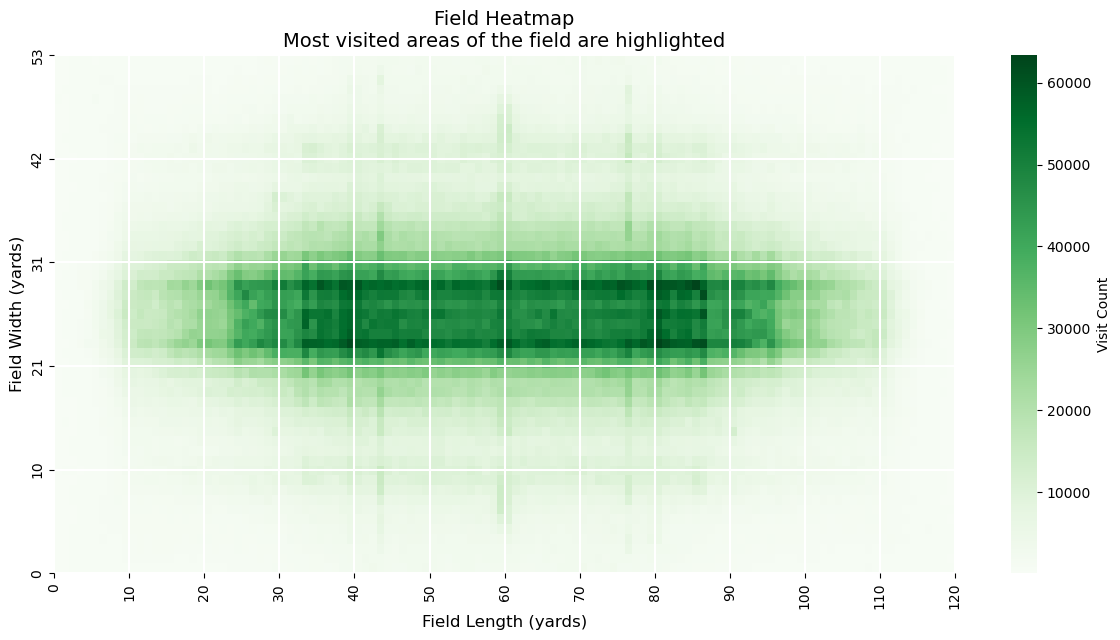

In [6]:
visualize_field_heatmap(player_df) #you can see some areas of the field are more 'busy' than others (mostly near the hashes)

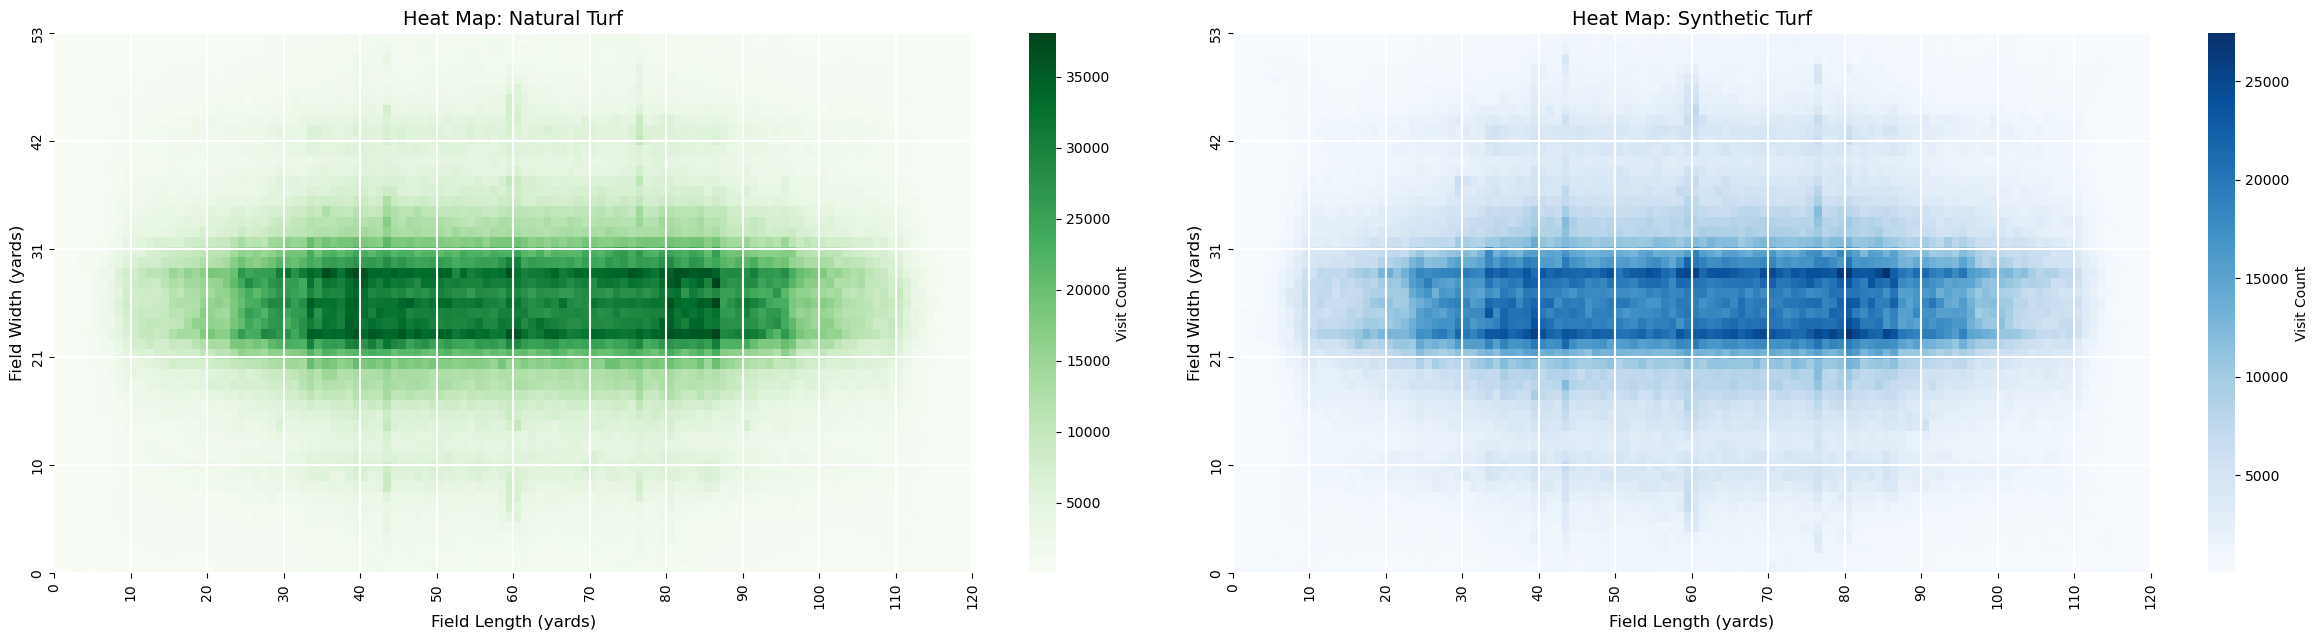

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(24, 6.5))

# left heatmap
visualize_field_heatmap_w_subplots(
    ngs_df=player_df_fieldtype.query('FieldType == "Natural"'),
    annotate=False,
    cmap="Greens",
    ax=axes[0]
)
axes[0].set_title("Heat Map: Natural Turf", fontsize=14)

# right heatmap
visualize_field_heatmap_w_subplots(
    ngs_df=player_df_fieldtype.query('FieldType == "Synthetic"'),
    annotate=False,
    cmap="Blues",
    ax=axes[1]
)
axes[1].set_title("Heat Map: Synthetic Turf", fontsize=14)

plt.tight_layout()
plt.show() #no difference in activity between natural and synthetic turf

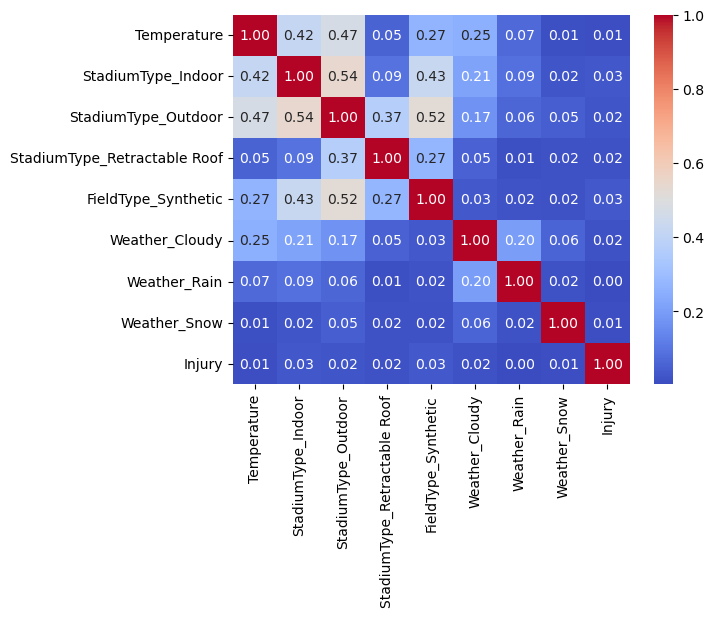

In [8]:
import seaborn as sns
# Correlation matrix
corr_df = game_injury_df_dummies[['Temperature', 'StadiumType_Indoor', 
                                  'StadiumType_Outdoor', 'StadiumType_Retractable Roof',
                                  'FieldType_Synthetic', 'Weather_Cloudy', 
                                  'Weather_Rain', 'Weather_Snow', 
                                  'Injury']]
corr_df = corr_df.corr().abs()

sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt='.2f', xticklabels=corr_df.columns, yticklabels=corr_df.columns)
plt.show() # very little correlation with injury target


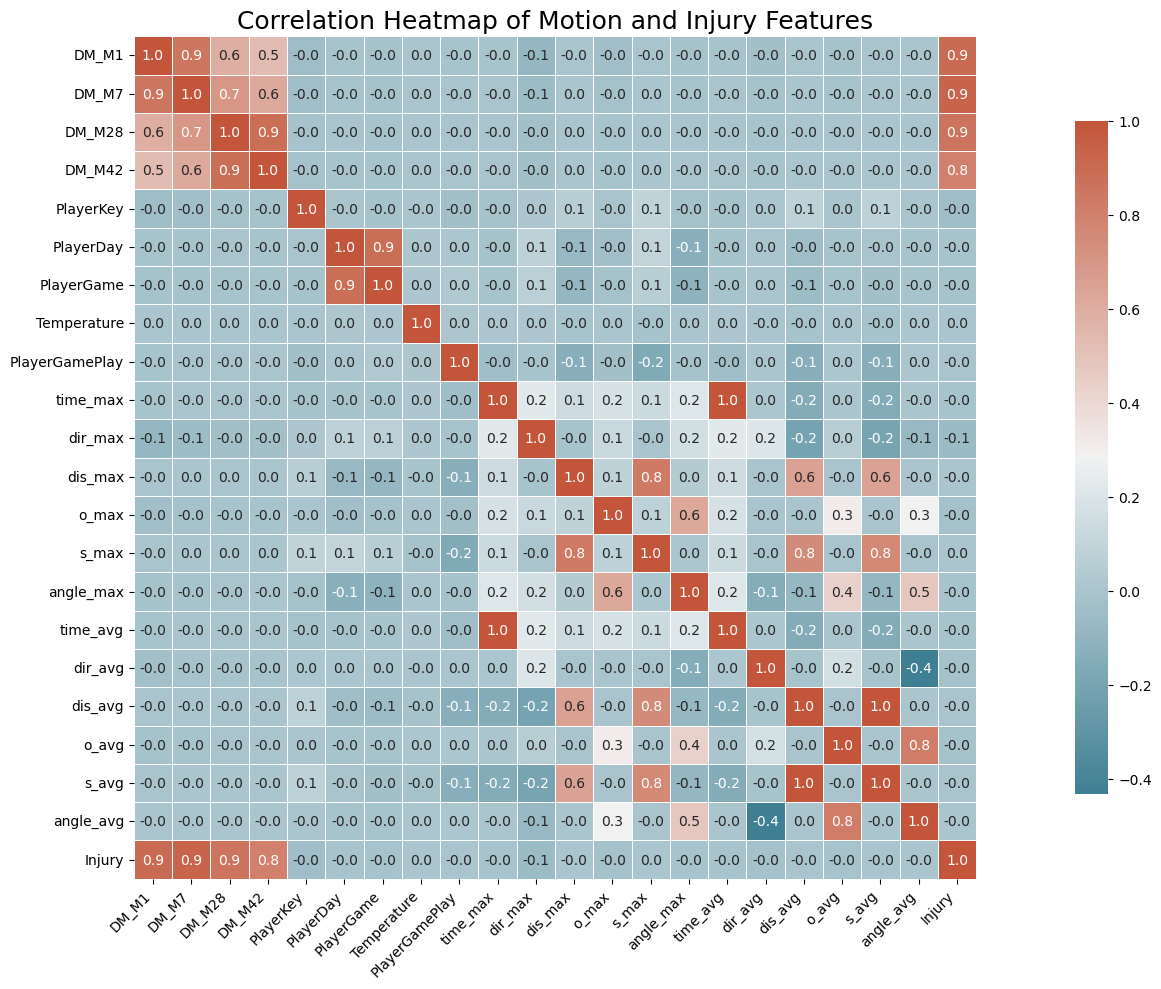

In [9]:
# Select only numeric columns and compute correlation matrix
corr_df = motion_df.select_dtypes(include=['number']).corr()

# --- Plot the heatmap ---
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(
    corr_df,
    cmap=sns.diverging_palette(220, 20, as_cmap=True),
    annot=True,
    fmt='.1f',
    square=True,
    linewidths=0.5,                     # <-- adds clean grid lines
    cbar_kws={"shrink": 0.8},           # <-- shrink colorbar a bit
    ax=ax,
    xticklabels=corr_df.columns, 
    yticklabels=corr_df.columns
)

ax.set_title('Correlation Heatmap of Motion and Injury Features', fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show() # no correlation between injury and motion, possible leakage into the dataset


### Draw bubble plots.

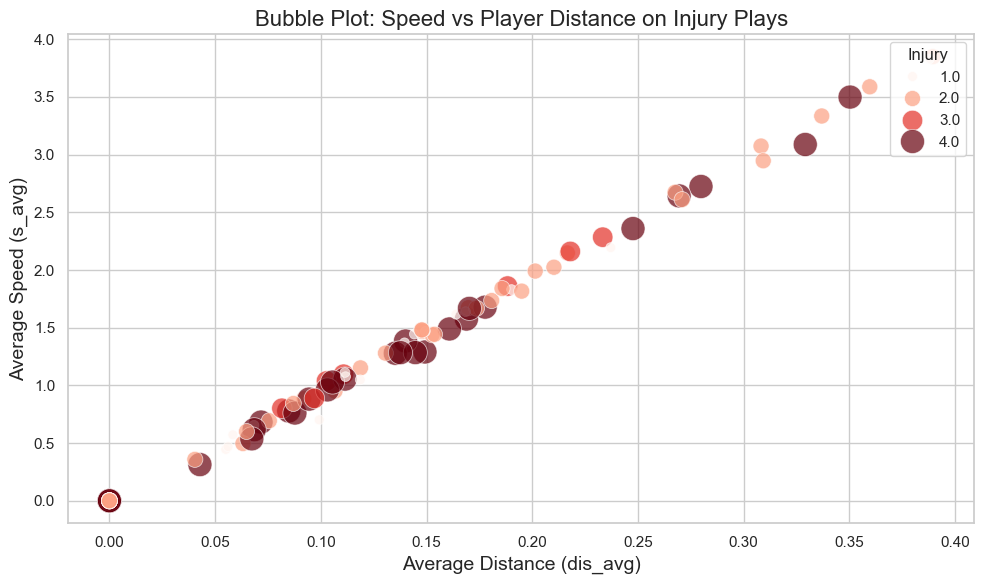

In [10]:
sns.set_theme(style='whitegrid')

# Create a bubble plot
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=motion_df[motion_df['Injury'] > 0],  # only injured plays
    x='dis_avg',
    y='s_avg',
    size='Injury',
    hue='Injury',
    palette='Reds',
    sizes=(50, 300),
    alpha=0.7,
    edgecolor='w'
)


plt.title('Bubble Plot: Speed vs Player Distance on Injury Plays', fontsize=16)
plt.xlabel('Average Distance (dis_avg)', fontsize=14)
plt.ylabel('Average Speed (s_avg)', fontsize=14)
plt.legend(title='Injury', loc='upper right')
plt.tight_layout()
plt.show() # no real cluster where injuries occur (no more likely to happen after a lot of distance or short distance)

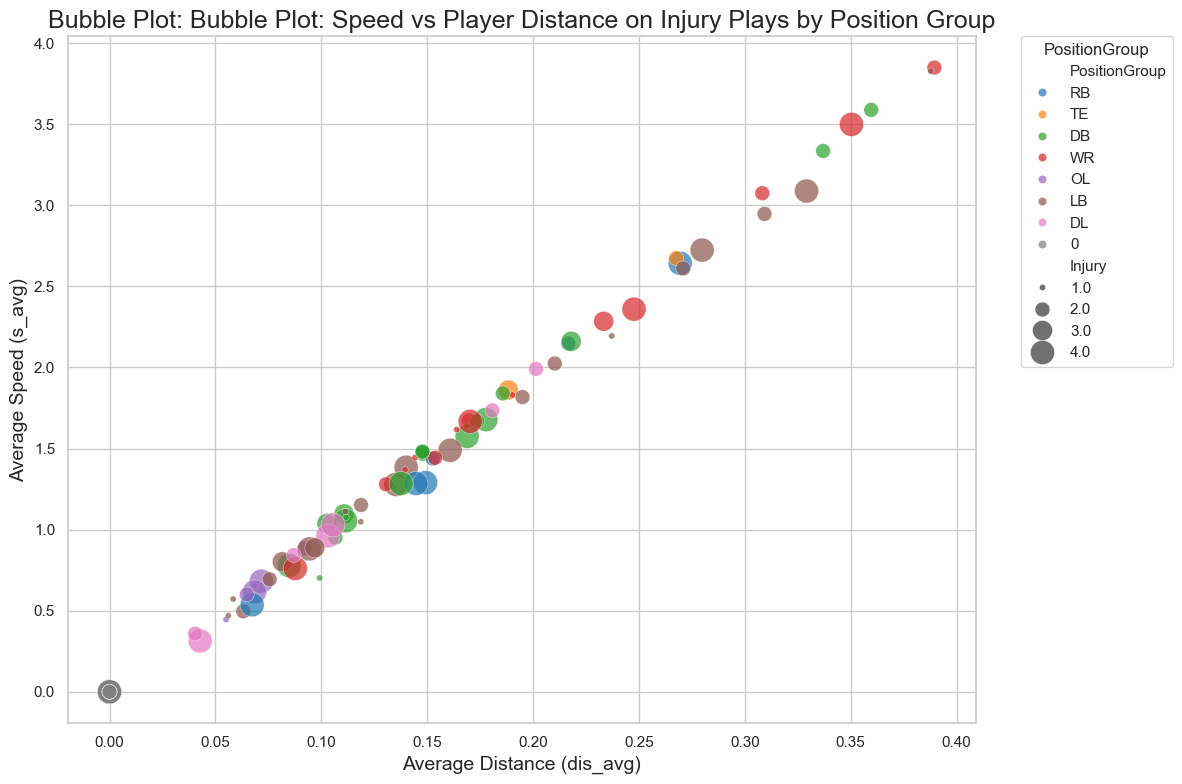

In [11]:
# Make sure PositionGroup is clean
motion_df['PositionGroup'] = motion_df['PositionGroup'].fillna('Unknown')

# Create the bubble plot
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=motion_df[motion_df['Injury'] > 0],  # only injured plays,
    x='dis_avg',               # x-axis: average distance
    y='s_avg',                 # y-axis: average speed
    size='Injury',             # bubble size based on Injury
    hue='PositionGroup',       # bubble color based on PositionGroup
    palette='tab10',           # 10-class categorical color map
    sizes=(20, 300),           # smaller size range
    alpha=0.7,
    edgecolor='w'
)

plt.title('Bubble Plot: Bubble Plot: Speed vs Player Distance on Injury Plays by Position Group', fontsize=18)
plt.xlabel('Average Distance (dis_avg)', fontsize=14)
plt.ylabel('Average Speed (s_avg)', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='PositionGroup')
plt.tight_layout()
plt.show() # no real relationship between position group and the distance or speed traveled before injury


### Principal Component Analysis - Perform Principal Component Analysis to find out the directions in which the data varies.



### Can your Represent the data using only its projection onto the first principal component, using the methods described in week 8, How much of the variance would this capture?

PS Note - Ths target variable of this data set ("Injury") is an incredibly poor fit for linear regression. we'll build a different subset of the data and test something that is a better fit for that algorithm - I'm gonna go with 'max_speed', given player position and the other motion data - should be easier to follow and work with 

In [12]:
# set up our new dataset
player_df_grouped = player_df.groupby('PlayKey').agg({
    's': ['mean', 'max', 'std'],
    'x': ['min', 'max', 'mean'],
    'y': ['min', 'max', 'mean']
})

player_df_grouped = player_df_grouped.reset_index()
player_df_grouped.columns = ['PlayKey', 's_mean', 's_max', 's_std', 'x_min', 'x_max', 'x_mean', 'y_min', 'y_max', 'y_mean']
player_df_grouped = player_df_grouped.merge(play_df[['PlayKey', 'RosterPosition', 'FieldType', 'PlayType']], left_on='PlayKey', right_on='PlayKey', how='left')

# pick out target and features
X_linreg = player_df_grouped.drop(columns=['PlayKey', 's_max', 's_mean', 's_std'])
y_linreg = player_df_grouped['s_max']
X_linreg = pd.get_dummies(X_linreg, columns=['RosterPosition', 'FieldType', 'PlayType'], drop_first=True)

# prep data for PCA
bool_cols = X_linreg.select_dtypes(include=['bool']).columns
# Convert boolean columns to integers
X_linreg[bool_cols] = X_linreg[bool_cols].astype(int)
X_linreg.head()


,x_min,x_max,x_mean,y_min,y_max,y_mean,RosterPosition_Defensive Lineman,RosterPosition_Kicker,RosterPosition_Linebacker,RosterPosition_Offensive Lineman,...,PlayType_Extra Point,PlayType_Field Goal,PlayType_Kickoff,PlayType_Kickoff Not Returned,PlayType_Kickoff Returned,PlayType_Pass,PlayType_Punt,PlayType_Punt Not Returned,PlayType_Punt Returned,PlayType_Rush
0,84.36,91.49,87.665753,23.62,29.85,28.221104,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,13.39,18.56,15.893188,22.07,27.49,24.006486,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,7.16,19.65,13.429593,22.56,28.18,24.698211,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,45.55,49.93,46.824706,20.87,24.66,22.817115,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,45.20,49.21,47.015586,21.53,23.97,22.936367,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
# make a copy for linear regression comparison
X_pca = X_linreg.copy()
#scale the data
scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

# Fit PCA
pca = PCA(n_components=1)
pca.fit(X_pca_scaled)

# get first principal component
PC1 = pca.components_[0]

# Project data onto PC1
projections = X_pca_scaled @ PC1  # or np.dot(X_scaled, PC1)

# 5. Reconstruct the data using only PC1
X__pca_reconstructed = np.outer(projections, PC1)

# 6. How much variance is captured?
variance_pc1 = pca.explained_variance_ratio_[0]
print(f"Variance captured by PC1: {variance_pc1:.4f} ({variance_pc1 * 100:.2f}%)")

Variance captured by PC1: 0.1098 (10.98%)


In [14]:
# how many pcs to capture 80% of the variance?

# make a copy for linear regression comparison
X_pca = X_linreg.copy()

#scale the data
scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

# Fit PCA
pca = PCA()
pca.fit(X_pca_scaled)


# 3. Compute cumulative explained variance
cumvar = np.cumsum(pca.explained_variance_ratio_)

# 4. Find the first index where cumulative variance ≥ 0.80
n_components_80 = np.argmax(cumvar >= 0.80) + 1

print(f"{n_components_80} components are needed to capture ≥ 80% of the variance")
print(f"Cumulative variance at {n_components_80} components: {cumvar[n_components_80-1]:.4f} ({cumvar[n_components_80-1]*100:.1f}%)")

16 components are needed to capture ≥ 80% of the variance
Cumulative variance at 16 components: 0.8334 (83.3%)


No, representing the data using only its projection onto the first principal component is not sufficient. The first principal component only captures 11% of the total variance, meaning that significant information would be lost.

### Try performing linear regression analysis using different sets of features.  Which features seem most likely to be useful to predict other features?

*Note - this dataset is not a good fit for linear regression*, see above note

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X_linreg, y_linreg, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R^2 score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {np.sqrt(mse):.4f}")

R^2 score: 0.6968
Mean Squared Error: 1.2484
Root Mean Squared Error: 1.1173


In [16]:
# Get feature importances (coefficients)
feature_importance = model.coef_

# Match back to feature names
importance_df = pd.DataFrame({
    'feature': X_linreg.columns,
    'importance': feature_importance
}).sort_values(by='importance', key=abs, ascending=False)

print(importance_df)

                             feature  importance
9   RosterPosition_Offensive Lineman   -1.192471
7              RosterPosition_Kicker   -1.159595
19     PlayType_Kickoff Not Returned    1.154480
20         PlayType_Kickoff Returned    1.090490
17               PlayType_Field Goal   -1.010909
16              PlayType_Extra Point   -1.008110
10        RosterPosition_Quarterback   -0.938411
23        PlayType_Punt Not Returned    0.847095
24            PlayType_Punt Returned    0.783311
6   RosterPosition_Defensive Lineman   -0.729802
18                  PlayType_Kickoff    0.653216
22                     PlayType_Punt    0.400692
13          RosterPosition_Tight End   -0.384450
21                     PlayType_Pass    0.355623
14      RosterPosition_Wide Receiver    0.162605
8          RosterPosition_Linebacker   -0.144939
11       RosterPosition_Running Back    0.102213
3                              y_min   -0.069224
4                              y_max    0.068909
25                  

In [17]:
# Week 8-style feature correlation/comparison
columns = X_linreg.columns
results = []

for i, col_target in enumerate(columns):
    best_score = -np.inf
    best_predictor = None
    
    # Loop through all other columns as predictors
    for col_predictor in columns:
        if col_target == col_predictor:
            continue  # don't predict a feature from itself
        
        # Predictor column must be reshaped into 2D
        X_single = X_linreg[[col_predictor]]  # make it a dataframe, not a series
        y_single = X_linreg[col_target]
        
        # Fit linear regression
        model = LinearRegression()
        model.fit(X_single, y_single)
        
        preds = model.predict(X_single)
        
        # Compute R^2 score (or you could use correlation coefficient if you want)
        score = r2_score(y_single, preds)
        
        if score > best_score:
            best_score = score
            best_predictor = col_predictor
    
    # Save the best predictor for this target feature
    results.append({
        'Target Feature': col_target,
        'Best Predictor': best_predictor,
        'Best R^2 Score': best_score
    })

# Compile results into a dataframe
summary_df = pd.DataFrame(results)
summary_df


,Target Feature,Best Predictor,Best R^2 Score
0,x_min,x_mean,0.916246
1,x_max,x_mean,0.916559
2,x_mean,x_max,0.916559
3,y_min,y_mean,0.641600
4,y_max,y_mean,0.640430
5,y_mean,y_min,0.641600
6,RosterPosition_Defensive Lineman,RosterPosition_Linebacker,0.029912
7,RosterPosition_Kicker,PlayType_Extra Point,0.007283
8,RosterPosition_Linebacker,RosterPosition_Offensive Lineman,0.049917
9,RosterPosition_Offensive Lineman,RosterPosition_Linebacker,0.049917


Our results are actually pretty good here, but maybe a little misleading as we haven't dropped the s_std from our dataset yet. 

# Dataset 2

In [18]:
import pandas as pd
import numpy as np

def load_and_normalize(path):
    """Load a CSV, strip and lowercase its column names."""
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip().str.lower()
    return df

# 1. LOAD & NORMALIZE
# -------------------
games            = load_and_normalize('datasets/NFL-Punt-Analytics-Competition/game_data.csv')
play_info        = load_and_normalize('datasets/NFL-Punt-Analytics-Competition/play_information.csv')
player_roles     = load_and_normalize('datasets/NFL-Punt-Analytics-Competition/play_player_role_data.csv')
player_positions = load_and_normalize('datasets/NFL-Punt-Analytics-Competition/player_punt_data.csv')
video_review     = load_and_normalize('datasets/NFL-Punt-Analytics-Competition/video_review.csv')

# NGS chunks for 2016 & 2017
ngs_paths = [
    'datasets/NFL-Punt-Analytics-Competition/NGS-2016-pre.csv',
    'datasets/NFL-Punt-Analytics-Competition/NGS-2016-post.csv',
    'datasets/NFL-Punt-Analytics-Competition/NGS-2016-reg-wk1-6.csv',
    'datasets/NFL-Punt-Analytics-Competition/NGS-2016-reg-wk7-12.csv',
    'datasets/NFL-Punt-Analytics-Competition/NGS-2016-reg-wk13-17.csv',
    'datasets/NFL-Punt-Analytics-Competition/NGS-2017-pre.csv',
    'datasets/NFL-Punt-Analytics-Competition/NGS-2017-post.csv',
    'datasets/NFL-Punt-Analytics-Competition/NGS-2017-reg-wk1-6.csv',
    'datasets/NFL-Punt-Analytics-Competition/NGS-2017-reg-wk7-12.csv',
    'datasets/NFL-Punt-Analytics-Competition/NGS-2017-reg-wk13-17.csv',
]
ngs = pd.concat([load_and_normalize(p) for p in ngs_paths], ignore_index=True)


# 2. CLEAN & CAST
# ----------------

# Parse any ISO‐style dates in games & play_info
for df in (games, play_info):
    if 'game_date' in df.columns:
        df['game_date'] = pd.to_datetime(df['game_date'])

# Make sure keys are ints
for df in (player_roles, player_positions, video_review):
    for col in ('gamekey', 'playid', 'gsisid'):
        if col in df.columns:
            df[col] = df[col].astype(int)

# Parse NGS timestamps if present
if 'time' in ngs.columns:
    ngs['time'] = pd.to_datetime(ngs['time'])


# 3. MERGE BASE TABLE
# -------------------

# Start from each player’s role in each play
df = player_roles.copy()

# Merge play-level data
df = df.merge(
    play_info,
    on=['gamekey','playid'],
    how='left',
    validate='many_to_one'
)

# Merge game-level data
df = df.merge(
    games.drop(columns=['game_date'], errors='ignore'),
    on='gamekey',
    how='left',
    validate='many_to_one'
)

# Merge typical football position
if {'gamekey','gsisid','position'}.issubset(player_positions.columns):
    df = df.merge(
        player_positions[['gamekey','gsisid','position']],
        on=['gamekey','gsisid'],
        how='left'
    )


# 4. ADD VIDEO REVIEW AS FEATURES
# --------------------------------

# Select the video_review columns we want
video_feats = video_review[[
    'gamekey','playid','gsisid',
    'player_activity_derived',
    'turnover_related',
    'primary_impact_type',
    'primary_partner_activity_derived',
    'friendly_fire'
]]

# Merge them in
df = df.merge(
    video_feats,
    on=['gamekey','playid','gsisid'],
    how='left'
)

# Fill NaNs for non-injured rows
for c in [
    'player_activity_derived',
    'turnover_related',
    'primary_impact_type',
    'primary_partner_activity_derived',
    'friendly_fire'
]:
    df[c] = df[c].fillna('NoInjury')


# 5. BUILD TARGET—ANY INJURY
# --------------------------

inj = video_review[['gamekey','playid','gsisid']].copy()
inj['injury'] = 1

df = df.merge(inj, on=['gamekey','playid','gsisid'], how='left')
df['injury'] = df['injury'].fillna(0).astype(int)


# 6. AGGREGATE NGS INTO SUMMARY FEATURES
# ---------------------------------------

if {'gamekey','playid','gsisid','dis'}.issubset(ngs.columns):
    ngs_summary = (
        ngs
        .groupby(['gamekey','playid','gsisid'], as_index=False)
        .agg(
            total_distance = ('dis','sum'),
            max_step       = ('dis','max'),
            mean_step      = ('dis','mean'),
            n_timestamps   = ('time' if 'time' in ngs.columns else 'dis','count')
        )
    )
    df = df.merge(ngs_summary, on=['gamekey','playid','gsisid'], how='left')
else:
    df[['total_distance','max_step','mean_step','n_timestamps']] = 0


# 7. FINAL PREP FOR EDA & MODELING
# ---------------------------------

# Fill any remaining nulls in the summary stats
for col in ['total_distance','max_step','mean_step','n_timestamps']:
    if col in df.columns:
        df[col] = df[col].fillna(0)

# Define feature columns
feature_cols = [
    'position', 'role', 'season_year', 'week',
    'player_activity_derived',
    'turnover_related',
    'primary_impact_type',
    'primary_partner_activity_derived',
    'friendly_fire',
    'total_distance','max_step','mean_step','n_timestamps'
]
feature_cols = [c for c in feature_cols if c in df.columns]

# One‑hot encode categoricals
X = pd.get_dummies(df[feature_cols], drop_first=True)
y = df['injury']

# Quick check
print("X shape:", X.shape)
print("Injury prevalence:", y.mean())


/var/folders/4k/nl2zz_ln4d55dcscl_vvjglh0000gn/T/ipykernel_98585/4072727785.py:6: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


X shape: (146573, 73)
Injury prevalence: 0.0002524339407667169


## Dataset 2 Heatmaps

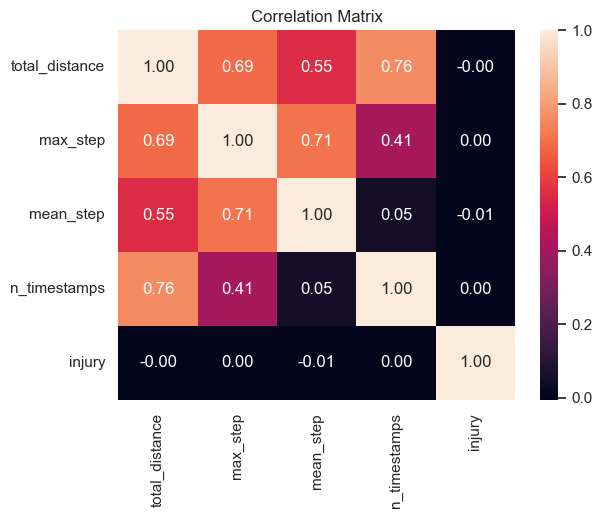

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

num = df[['total_distance','max_step','mean_step','n_timestamps','injury']]
sns.heatmap(num.corr(), annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

### Correlation Matrix
- All movement features correlate quite strongly among themselves (no surprise), but none correlates with injury.
- This again underscores that simple kinematic summaries alone won’t predict these extremely rare concussion cases.

In [23]:
# create role group

# Create the role_group column
mapping = {
    'PR':'Returner',
    'GL':'Gunner', 
    'GR':'Gunner',
    'PLW':'Wing',
    'PLG':'Wing',
    'PRG':'Wing',
    'PLL':'Wing',
    'VL' : 'Gunner',
}
df['role_group'] = df['role'].map(mapping)

In [24]:
# 2. Merge into the ngs DataFrame
ngs = ngs.merge(
    role_lookup,
    on=['gamekey','playid','gsisid'],
    how='left'
)

# 3. Now you can filter by role or role_group, e.g.:
ngs_gunners = ngs[ngs['role_group']=='Gunner']

# 2) Drop all the old one‑hot role_ columns
old_roles = [c for c in X.columns if c.startswith('role_')]
X = X.drop(columns=old_roles)

# 3) Add one‑hot encoding for the three groups
role_group_dummies = pd.get_dummies(df['role_group'], prefix='role_group', drop_first=True)
X = pd.concat([X.reset_index(drop=True), role_group_dummies.reset_index(drop=True)], axis=1)

print("New feature set:")
print(X.filter(like='role_group_').columns)

New feature set:
Index(['role_group_Returner', 'role_group_Wing'], dtype='object')


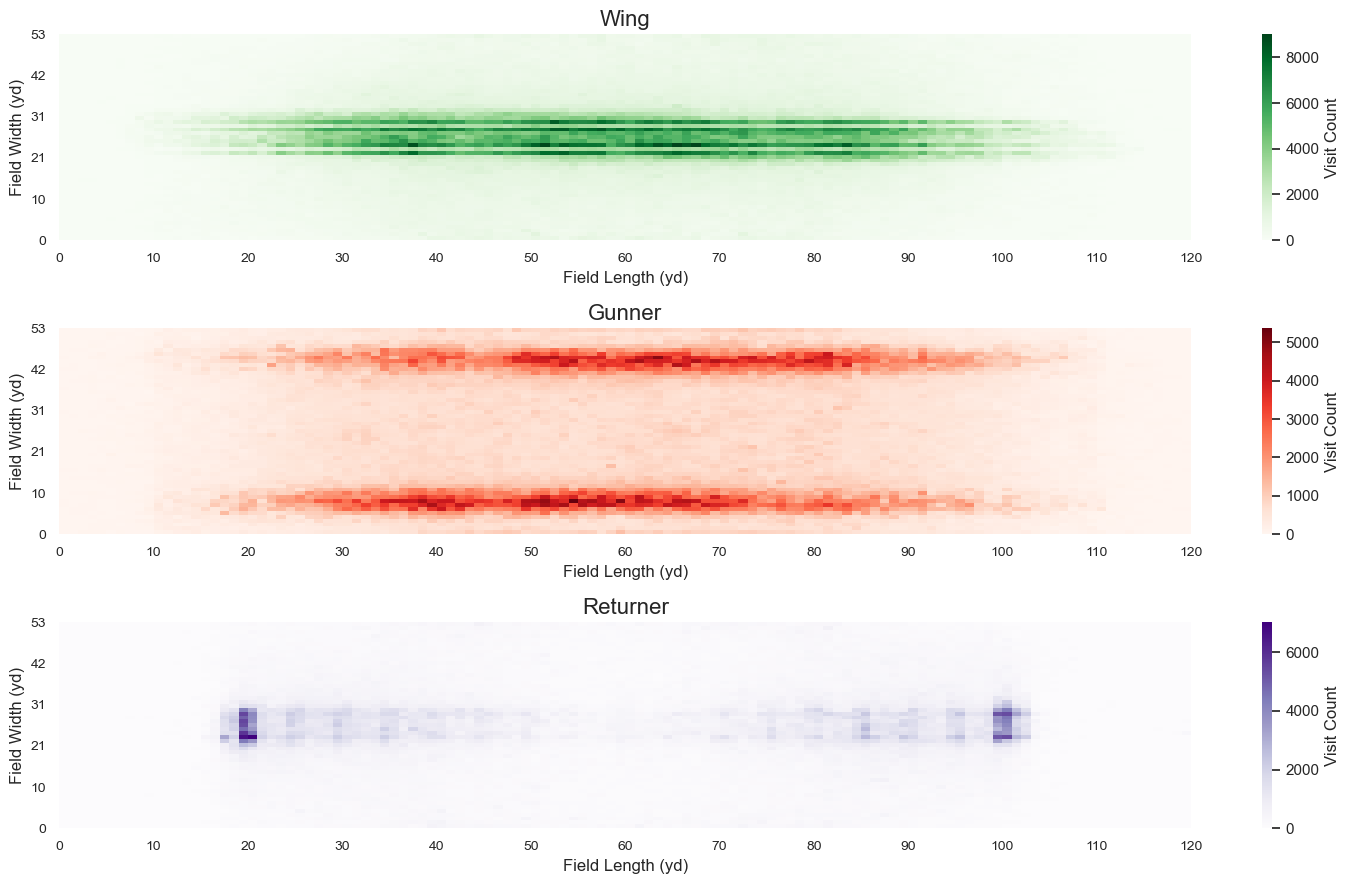

In [25]:
def visualize_field_heatmap_by_role(
    ngs_df,
    role_col='role_group',
    xbins=120,
    ybins=53,
    cmaps=None
):
    roles = ngs_df[role_col].unique()
    n = len(roles)
    
    if cmaps is None:
        default_list = ["Greens","Reds","Purples"]
        cmaps = {r: default_list[i % len(default_list)] for i,r in enumerate(roles)}
    
    # create a 3×1 grid instead of 1×3
    fig, axes = plt.subplots(n, 1, figsize=(15, 3 * n), squeeze=False)
    
    for ax, role in zip(axes.flatten(), roles):
        df_sub = ngs_df[ngs_df[role_col] == role]
        heat, y_edges, x_edges = np.histogram2d(
            df_sub['y'], df_sub['x'],
            bins=[ybins, xbins],
            range=[[0, 53.3], [0, 120]]
        )
        sns.heatmap(
            heat,
            cmap=cmaps.get(role, "Greens"),
            cbar_kws={'label': 'Visit Count'},
            xticklabels=False,
            yticklabels=False,
            ax=ax
        )
        ax.invert_yaxis()
        
        x_ticks = np.linspace(0, xbins, 13)
        y_ticks = np.linspace(0, ybins, 6)
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        ax.set_xticklabels(np.arange(0, 121, 10), fontsize=10)
        ax.set_yticklabels(np.linspace(0, 53.3, 6, dtype=int), fontsize=10)
        ax.grid(which='major', color='white', linewidth=1.5)
        ax.grid(which='minor', visible=False)
        
        ax.set_title(f"{role}", fontsize=16)
        ax.set_xlabel('Field Length (yd)', fontsize=12)
        ax.set_ylabel('Field Width (yd)', fontsize=12)
    
    plt.tight_layout()
    plt.show()

#drop na values
ngs_all_roles = ngs.dropna(subset=['role_group'])

# If you want specific color maps per role:
cm = {
    "Gunner":   "Reds",
    "Returner": "Purples",
    "Wing":     "Greens"
}
visualize_field_heatmap_by_role(ngs_all_roles, role_col='role_group', cmaps=cm)

## Bubble Plots

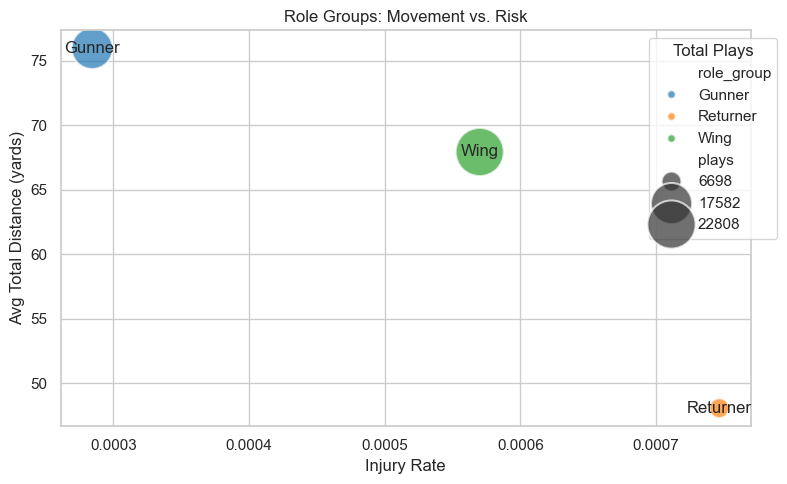

In [26]:
rg2 = (
    df.groupby('role_group')
      .agg(
        plays      = ('injury','count'),
        injuries   = ('injury','sum'),
        avg_dist   = ('total_distance','mean')
      )
      .reset_index()
)
rg2['rate'] = rg2['injuries'] / rg2['plays']

plt.figure(figsize=(8,5))
sns.scatterplot(
    data    = rg2,
    x       = 'rate',
    y       = 'avg_dist',
    size    = 'plays',
    hue     = 'role_group',
    palette = 'tab10',
    sizes   = (200,1200),
    alpha   = 0.7,
    edgecolor='w'
)
for _, r in rg2.iterrows():
    plt.text(r['rate'], r['avg_dist'], r['role_group'],
             ha='center', va='center', fontsize=12)

plt.xlabel('Injury Rate')
plt.ylabel('Avg Total Distance (yards)')
plt.title('Role Groups: Movement vs. Risk')
plt.legend(bbox_to_anchor=(1.05,1), title='Total Plays')
plt.tight_layout()
plt.show()

## PCA

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1) Copy your feature set for PCA
X_pca = X.copy()

# 2) Standardize (zero mean, unit variance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

# 3) Fit PCA with just one component
pca = PCA(n_components=1, random_state=42)
pca.fit(X_scaled)

# 4) Check variance explained by PC1
var_pc1 = pca.explained_variance_ratio_[0]
print(f"Variance captured by PC1: {var_pc1:.4f} ({var_pc1*100:>5.2f}%)")

Variance captured by PC1: 0.2989 (29.89%)


In [28]:
# how many pcs to capture 80% of the variance?

# make a copy for linear regression comparison
X_pca = X.copy()

#scale the data
scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

# Fit PCA
pca = PCA()
pca.fit(X_pca_scaled)


# 3. Compute cumulative explained variance
cumvar = np.cumsum(pca.explained_variance_ratio_)

# 4. Find the first index where cumulative variance ≥ 0.80
var_pc1 = pca.explained_variance_ratio_[0]
n_components_80 = np.argmax(cumvar >= 0.80) + 1

print(f"{n_components_80} components are needed to capture ≥ 80% of the variance")
print(f"Variance captured by PC1: {var_pc1:.4f} ({var_pc1*100:>5.2f}%)")
print(f"Cumulative variance at {n_components_80} components: {cumvar[n_components_80-1]:.4f} ({cumvar[n_components_80-1]*100:.1f}%)")

8 components are needed to capture ≥ 80% of the variance
Variance captured by PC1: 0.2989 (29.89%)
Cumulative variance at 8 components: 0.8016 (80.2%)


## Logistic Regression

Classification Report:

              precision    recall  f1-score   support

           0      1.000     0.765     0.867     36635
           1      0.000     0.444     0.001         9

    accuracy                          0.765     36644
   macro avg      0.500     0.605     0.434     36644
weighted avg      1.000     0.765     0.867     36644

5‑fold CV F1 score: 0.001 ± 0.000

Top 10 positive coefficients (↑ injury odds):
               feature      coef
0             max_step  1.251209
1            mean_step -1.141961
2      role_group_Wing  0.509515
3         n_timestamps -0.412618
4  role_group_Returner  0.342163
5       total_distance -0.156069
6          season_year  0.072073

Top 10 negative coefficients (↓ injury odds):
               feature      coef
0             max_step  1.251209
1            mean_step -1.141961
2      role_group_Wing  0.509515
3         n_timestamps -0.412618
4  role_group_Returner  0.342163
5       total_distance -0.156069
6          season_year  0.

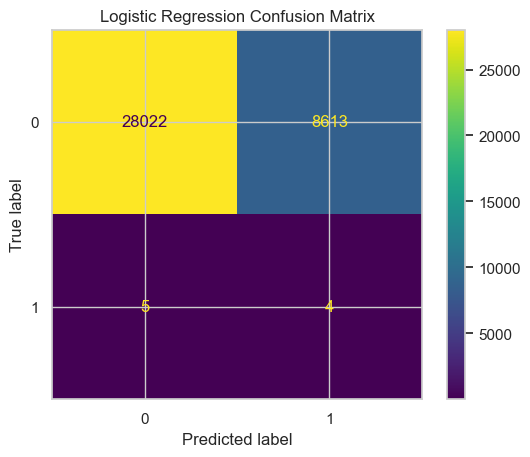

In [29]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# drop leaks
leak_cols = [c for c in X.columns if 
             c.startswith('player_activity_derived_') or
             c.startswith('turnover_related_') or
             c.startswith('primary_impact_type_') or
             c.startswith('primary_partner_activity_derived_') or
             c.startswith('friendly_fire_')]

X = X.drop(columns=leak_cols)

# Split into train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

# Scale & fit Logistic Regression with balanced weights
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    solver='liblinear',
    random_state=42
)
model.fit(X_train_scaled, y_train)

# Evaluate on test set
y_pred = model.predict(X_test_scaled)
print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=3))

# Cross‑validated F1 on training set
cv_scores = cross_val_score(
    model, X_train_scaled, y_train,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
print(f"5‑fold CV F1 score: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# Feature importances = absolute value of coefficients
coefs = model.coef_[0]
feat_imp = pd.DataFrame({
    'feature': X.columns,
    'coef':    coefs
})
feat_imp['abs_coef'] = np.abs(feat_imp['coef'])
feat_imp = feat_imp.sort_values('abs_coef', ascending=False).reset_index(drop=True)

print("\nTop 10 positive coefficients (↑ injury odds):")
print(feat_imp[['feature','coef']].head(10))

print("\nTop 10 negative coefficients (↓ injury odds):")
print(feat_imp[['feature','coef']].tail(10))

#confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Logistic Regression Confusion Matrix")
plt.show()


## Dataset 3

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
import io
import zipfile
import time
from tqdm import tqdm
import seaborn as sns

# Define the folder path
folder_path = 'datasets/nfl-big-data-bowl-2023.zip'
extract_path = 'datasets/nfl-big-data-bowl-2023'

# Check if the extraction directory already exists
if not os.path.exists(extract_path):
    # Unzip the file
    with zipfile.ZipFile(folder_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Extracted all files to {extract_path}")
else:
    print(f"Directory {extract_path} already exists, skipping extraction.")

# List all CSV files in the folder
csv_files = [f for f in os.listdir(extract_path) if f.endswith('.csv')]

# Initialize an empty dictionary to store dataframes
dataframes = {}

# Load each CSV file as a separate dataframe with a progress bar
for file in tqdm(csv_files, desc="Loading CSV files", unit="file"):
    file_path = os.path.join(extract_path, file)
    df_name = os.path.splitext(file)[0]
    dataframes[df_name] = pd.read_csv(file_path)

# Convert dictionary to global variables
for key, df in dataframes.items():
    globals()[key] = df

# Display the keys of the dataframes dictionary to verify
print("Loaded DataFrames:", list(dataframes.keys()))

# concat all motion data
all_weeks = pd.concat([week1, week2, week3, week4, week5, week6, week7, week8], ignore_index=True)
all_weeks = all_weeks.merge(players[['nflId', 'displayName', 'officialPosition']], on='nflId', how='left')

# group all motion data by gameId, playId, nflId, displayName, officialPosition, then calculate mean, max, std of s, a, x, y
motion_df = all_weeks.groupby(['gameId', 'playId', 'nflId', 'displayName', 'officialPosition']).agg({
    's': ['mean', 'max', 'std'],
    'a': ['mean', 'max', 'std'],
    'x': ['min', 'max', 'mean'],
    'y': ['min', 'max', 'mean']
})

# flatten the multi-level columns
motion_df = motion_df.reset_index()
motion_df.columns = ['_'.join(col).strip() if col[1] else col[0] for col in motion_df.columns.values]

# Merge pffScoutingData into motion_df
motion_df = motion_df.merge(pffScoutingData, on=['gameId', 'playId', 'nflId'], how='left')
motion_df = motion_df.merge(plays, on=['gameId', 'playId'], how='left')
ol = ['C', 'G', 'T', 'TE']
dl = ['DL', 'LB', 'DE', 'OLB', 'ILB', 'NT', 'MLB']
motion_df['OL'] = motion_df['officialPosition'].apply(lambda x: 1 if x in ol else 0)
motion_df['DL'] = motion_df['officialPosition'].apply(lambda x: 1 if x in dl else 0)

#create separate dataframes for OL and DL
ol_motion_df = motion_df[motion_df['OL'] == 1].copy()
dl_motion_df = motion_df[motion_df['DL'] == 1].copy()

Directory datasets/nfl-big-data-bowl-2023 already exists, skipping extraction.


Loading CSV files: 100%|██████████| 12/12 [00:04<00:00,  2.40file/s]


Loaded DataFrames: ['week1', 'week2', 'week3', 'pffScoutingData', 'plays', 'week7', 'week6', 'week4', 'week5', 'players', 'games', 'week8']


## Heatmaps

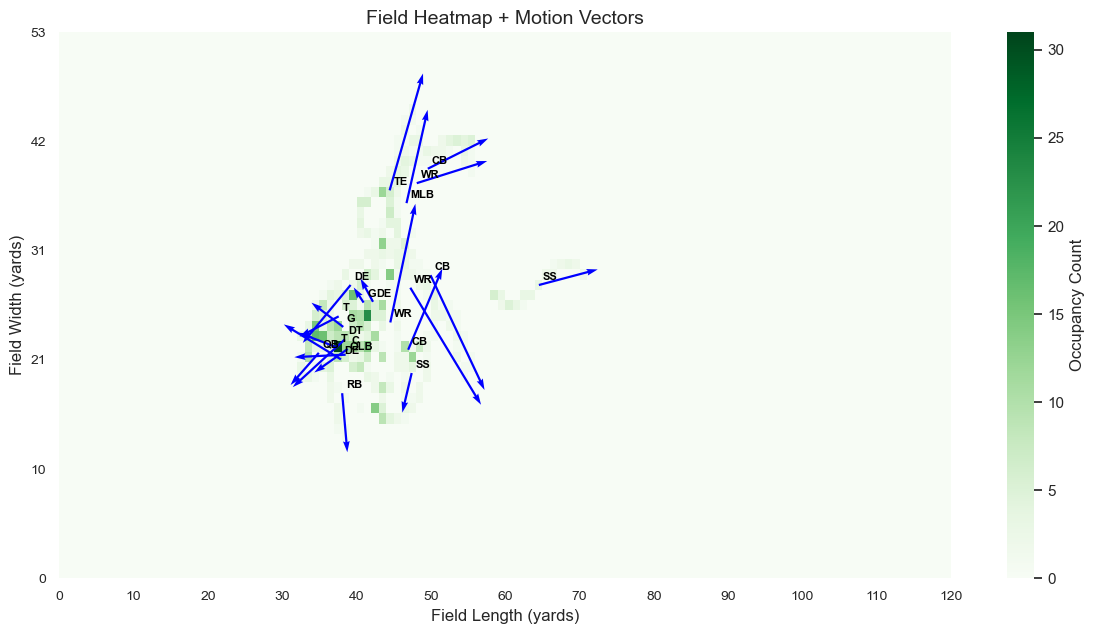

<Axes: title={'center': 'Field Heatmap + Motion Vectors'}, xlabel='Field Length (yards)', ylabel='Field Width (yards)'>

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_field_heatmap_with_motion(
    player_df,
    xbins=120,
    ybins=53,
    cmap="Greens",
    ax=None
):
    """
    Heatmap of the football field (120×53.3 yards) with motion vectors and position labels.
    
    player_df must have columns: 'x', 'y', 'gameId', 'playId', 'nflId', 'frameId', 'officialPosition'.
    If ax is None, creates its own figure/axes; otherwise draws on the provided ax.
    """
    # 1. Compute 2D histogram
    heat, y_edges, x_edges = np.histogram2d(
        player_df['y'], player_df['x'],
        bins=[ybins, xbins],
        range=[[0, 53.3], [0, 120]]
    )
    
    # 2. Create axes if needed
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6.5))
        created_fig = True

    # 3. Draw turf heatmap
    sns.heatmap(
        heat,
        cmap=cmap,
        cbar_kws={'label': 'Occupancy Count'},
        xticklabels=False,
        yticklabels=False,
        ax=ax
    )
    ax.invert_yaxis()

    # 4. Yard‐line grid and labels
    x_ticks = np.linspace(0, xbins, 13)      # 0,10,20,...,120
    y_ticks = np.linspace(0, ybins, 6)       # 0, ~10.66, ... 53.3
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.set_xticklabels(np.arange(0, 121, 10), fontsize=10)
    ax.set_yticklabels(np.linspace(0, 53.3, 6, dtype=int), fontsize=10)
    ax.grid(which='major', color='white', linewidth=1.5)
    ax.grid(which='minor', visible=False)

    ax.set_xlabel('Field Length (yards)', fontsize=12)
    ax.set_ylabel('Field Width (yards)', fontsize=12)
    if created_fig:
        ax.set_title('Field Heatmap + Motion Vectors', fontsize=14)

    # 5. Compute motion vectors per player
    motion_df = (
        player_df
        .sort_values(['gameId', 'playId', 'nflId', 'frameId'])
        .groupby(['gameId', 'playId', 'nflId'])
        .agg({
            'x': ['first', 'last'],
            'y': ['first', 'last'],
            'officialPosition': 'first'
        })
        .reset_index()
    )
    motion_df.columns = [
        'gameId','playId','nflId',
        'x_start','x_end','y_start','y_end','officialPosition'
    ]
    motion_df['dx'] = motion_df['x_end'] - motion_df['x_start']
    motion_df['dy'] = motion_df['y_end'] - motion_df['y_start']
    motion_df['x_mid'] = (motion_df['x_start'] + motion_df['x_end']) / 2
    motion_df['y_mid'] = (motion_df['y_start'] + motion_df['y_end']) / 2

    # 6. Draw arrows
    ax.quiver(
        motion_df['x_mid'], motion_df['y_mid'],
        motion_df['dx'], motion_df['dy'],
        color='blue', scale_units='xy', angles='xy', scale=1.5, width=0.0025
    )

    # 7. Label positions
    for _, row in motion_df.iterrows():
        ax.text(
            row['x_mid'] + 0.5, row['y_mid'] + 0.5,
            row['officialPosition'],
            fontsize=8, color='black', weight='bold'
        )

    if created_fig:
        plt.tight_layout()
        plt.show()

    return ax

visualize_field_heatmap_with_motion(all_weeks.query("gameId == 2021090900 and playId == 97"))

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline

# set up dataset
feature_cols = ['s_mean', 's_max', 's_std', 'a_mean', 'a_max', 'a_std', 'x_min',
       'x_max', 'x_mean', 'y_min', 'y_max', 'y_mean', 'defendersInBox', 'absoluteYardlineNumber',
       'pff_beatenByDefender', 'pff_hitAllowed', 'pff_hurryAllowed',
       'pff_sackAllowed', 'pff_blockType', 'pff_backFieldBlock', 'playResult']

motion_model = motion_df[feature_cols].copy()
motion_model = motion_model.dropna(subset=['pff_blockType', 'pff_backFieldBlock', 'defendersInBox'])

X = motion_model.drop(columns=['playResult'])
y = motion_model['playResult']

X = pd.get_dummies(X, columns=['pff_blockType'], drop_first=True, dtype='int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

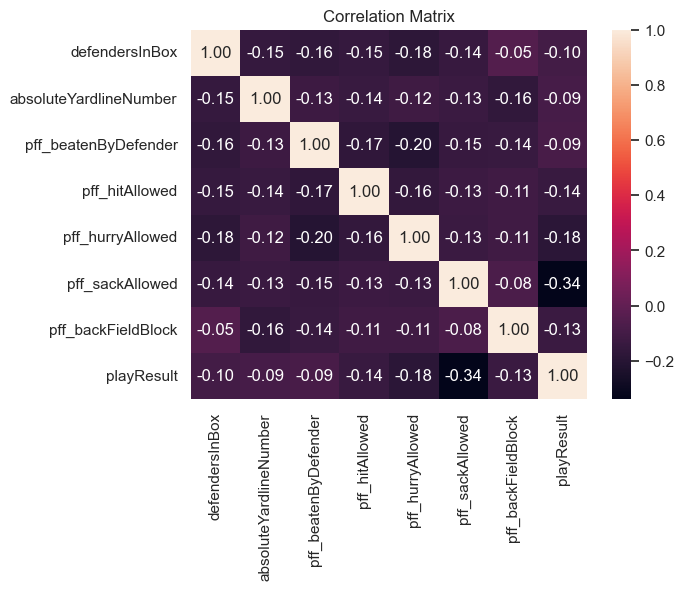

In [33]:
heatmap_cols = ['defendersInBox',
       'absoluteYardlineNumber', 'pff_beatenByDefender', 'pff_hitAllowed',
       'pff_hurryAllowed', 'pff_sackAllowed',
       'pff_backFieldBlock', 'playResult']

heatmap_df = motion_model[heatmap_cols].corr()

sns.heatmap(heatmap_df.corr(), annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## Visualize Target Variable

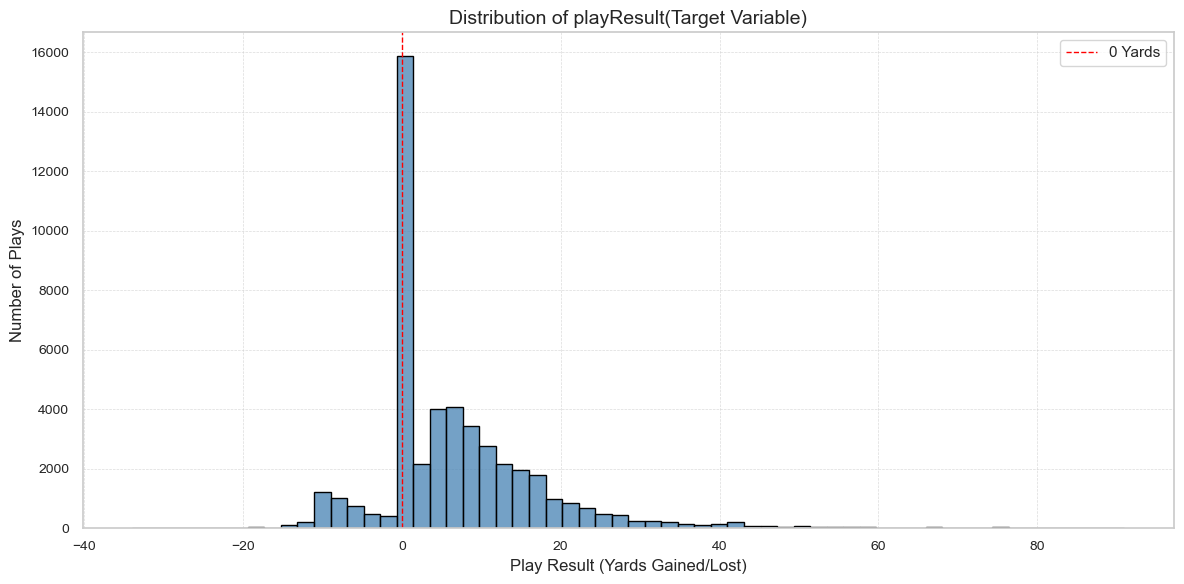

In [36]:
plt.figure(figsize=(12, 6))  # Make the plot wider
sns.histplot(motion_model['playResult'], bins=60, kde=False, color='steelblue', edgecolor='black')

# Add vertical line at 0 for reference
plt.axvline(0, color='red', linestyle='--', linewidth=1, label='0 Yards')

# Axis labels and title
plt.xlabel('Play Result (Yards Gained/Lost)', fontsize=12)
plt.ylabel('Number of Plays', fontsize=12)
plt.title('Distribution of playResult(Target Variable)', fontsize=14)

# Tweak tick marks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show grid for better readability
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.legend()
plt.tight_layout()
plt.show()

In [40]:
percentage_zero_playResult = (len(motion_model.query('playResult == 0')) / len(motion_model)) * 100
print(f"Percentage of motion_model where playResult == 0: {percentage_zero_playResult:.2f}%")

Percentage of motion_model where playResult == 0: 31.87%


## Bubble Plot

/var/folders/4k/nl2zz_ln4d55dcscl_vvjglh0000gn/T/ipykernel_98585/3375390512.py:46: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


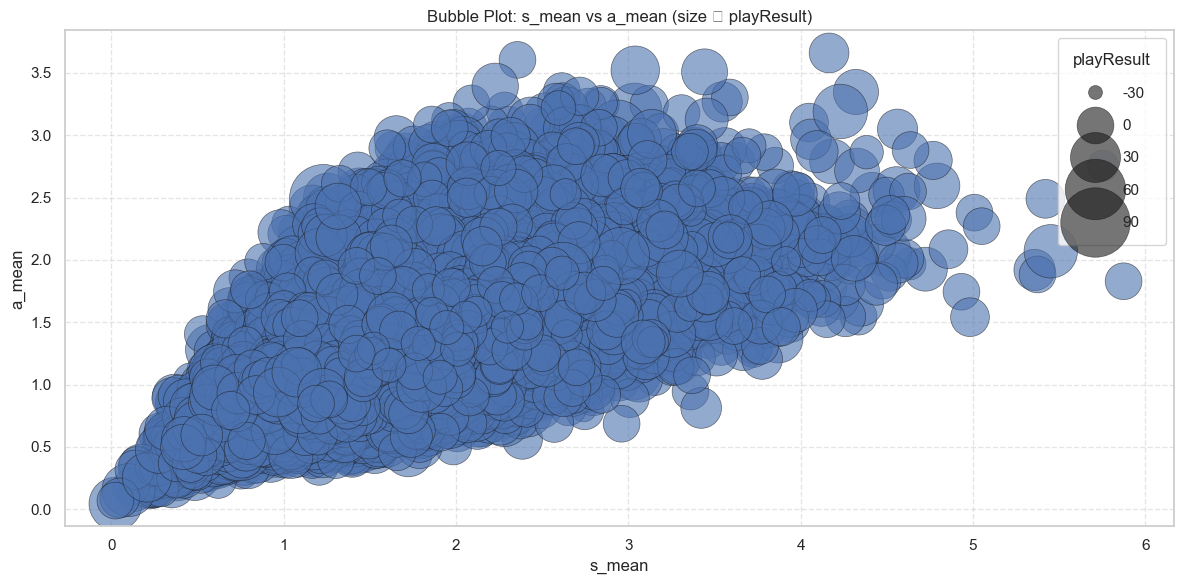

In [41]:
# bubble plot dataset
motion_model_bubble = motion_model.copy()
x_col = 's_mean'
y_col = 'a_mean'
size_col = 'playResult'

# shift to positive & scale up
min_val = motion_model_bubble[size_col].min()
bubble_sizes = (motion_model_bubble[size_col] - min_val + 1) * 20

plt.figure(figsize=(12, 6))

# after you do plt.scatter(...), capture the PathCollection:
sc = plt.scatter(
    motion_model_bubble[x_col],
    motion_model_bubble[y_col],
    s=bubble_sizes,
    alpha=0.6,
    marker='o',
    edgecolors='k',
    linewidths=0.5,
    color='C0',
)

# legend_elements with func to invert your sizing, fmt to round
handles, labels = sc.legend_elements(
    prop="sizes",
    num=4,
    func=lambda s: (s / 20 + min_val - 1),
    fmt="{x:.0f}"
)

plt.legend(
    handles, 
    labels,
    title=size_col,
    loc="upper right",
    labelspacing=1.2,
    borderpad=1
)

plt.title('Bubble Plot: s_mean vs a_mean (size ∝ playResult)')
plt.xlabel('s_mean', fontsize=12)
plt.ylabel('a_mean', fontsize=12)
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## PCA

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit PCA with all components
pca = PCA()
pca.fit(X_scaled)

# Compute cumulative explained variance
cumvar = np.cumsum(pca.explained_variance_ratio_)

# Find the first index where cumulative variance ≥ 0.80
n_components_80 = np.argmax(cumvar >= 0.80) + 1

print(f"{n_components_80} components are needed to capture ≥ 80% of the variance")
print(f"Cumulative variance at {n_components_80} components: {cumvar[n_components_80-1]:.4f} ({cumvar[n_components_80-1]*100:.1f}%)")

13 components are needed to capture ≥ 80% of the variance
Cumulative variance at 13 components: 0.8004 (80.0%)


## Linear Regression & Feature Importance

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R^2 score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

R^2 score: 0.0208
Mean Squared Error: 111.3174


In [44]:
# Get feature importances (coefficients)
feature_importance = model.coef_

# Match back to feature names
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importance
}).sort_values(by='importance', key=abs, ascending=False)

print(importance_df)

                   feature  importance
7                    x_max  -12.084225
8                   x_mean    6.545830
6                    x_min    5.873748
10                   y_max   -1.751530
9                    y_min    1.719707
22        pff_blockType_PA    1.180421
17         pff_sackAllowed   -1.134029
0                   s_mean    0.947565
23        pff_blockType_PP    0.780716
25        pff_blockType_PT    0.587578
1                    s_max   -0.565657
19        pff_blockType_CH    0.559077
20        pff_blockType_CL    0.477579
28        pff_blockType_SW    0.460051
29        pff_blockType_UP    0.411549
2                    s_std    0.390392
16        pff_hurryAllowed   -0.305857
13  absoluteYardlineNumber   -0.242787
21        pff_blockType_NB    0.241564
27        pff_blockType_SR    0.186471
5                    a_std    0.185740
18      pff_backFieldBlock    0.165400
12          defendersInBox   -0.162234
15          pff_hitAllowed   -0.161733
26        pff_blockType_P

In [45]:
# Week 8-style feature correlation/comparison
columns = X.columns
results = []

for i, col_target in enumerate(columns):
    best_score = -np.inf
    best_predictor = None
    
    # Loop through all other columns as predictors
    for col_predictor in columns:
        if col_target == col_predictor:
            continue  # don't predict a feature from itself
        
        # Predictor column must be reshaped into 2D
        X_single = X[[col_predictor]]  # make it a dataframe, not a series
        y_single = X[col_target]
        
        # Fit linear regression
        model = LinearRegression()
        model.fit(X_single, y_single)
        
        preds = model.predict(X_single)
        
        # Compute R^2 score (or you could use correlation coefficient if you want)
        score = r2_score(y_single, preds)
        
        if score > best_score:
            best_score = score
            best_predictor = col_predictor
    
    # Save the best predictor for this target feature
    results.append({
        'Target Feature': col_target,
        'Best Predictor': best_predictor,
        'Best R^2 Score': best_score
    })

# Compile results into a dataframe
summary_df = pd.DataFrame(results)
summary_df


,Target Feature,Best Predictor,Best R^2 Score
0,s_mean,s_max,0.761495
1,s_max,s_std,0.902235
2,s_std,s_max,0.902235
3,a_mean,a_std,0.684124
4,a_max,a_std,0.891780
5,a_std,a_max,0.891780
6,x_min,x_mean,0.997213
7,x_max,x_mean,0.997261
8,x_mean,x_max,0.997261
9,y_min,y_mean,0.867063


# 4. Storytelling With Data plot

Reproduce any graph of your choice in p. 136-150 of the Storytelling With Data book as best you can. ("The power of super-categories" to the end of chapter 5). You do not have to get the exact data values right, just the overall look and feel.

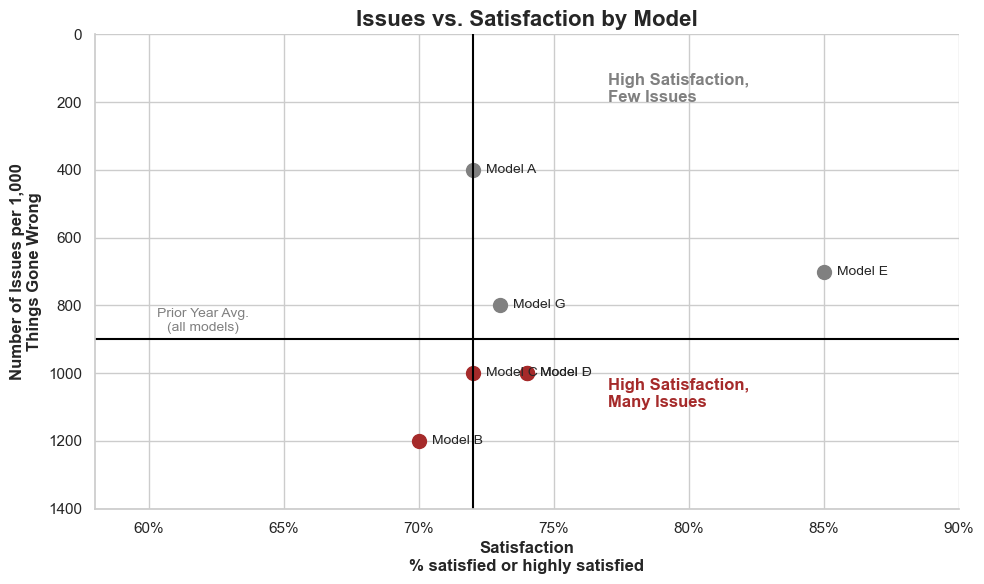

In [46]:
# Data from your image
models = ['Model A', 'Model G', 'Model E', 'Model C', 'Model D', 'Model F', 'Model B']
satisfaction = [72, 73, 85, 72, 74, 74, 70]  # x-axis: % satisfied
issues = [400, 800, 700, 1000, 1000, 1000, 1200]  # y-axis: number of issues per 1,000

# Colors: grey for models A, G, E; red for models C, D, F, B
colors = ['grey', 'grey', 'grey', 'brown', 'brown', 'brown', 'brown']

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter points
for i in range(len(models)):
    ax.scatter(satisfaction[i], issues[i], color=colors[i], s=100)
    ax.text(satisfaction[i]+0.5, issues[i], models[i], verticalalignment='center', fontsize=10)

# Horizontal and vertical reference lines
ax.axhline(900, color='black')  # y=900 is "Prior Year Avg."
ax.axvline(72, color='black')   # x=72 is satisfaction split

# Annotations
ax.text(62, 875, 'Prior Year Avg.\n(all models)', ha='center', fontsize=10, color='gray')

# Quadrant labels
ax.text(77, 200, 'High Satisfaction,\nFew Issues', fontsize=12, fontweight='bold', color='gray')
ax.text(77, 1100, 'High Satisfaction,\nMany Issues', fontsize=12, fontweight='bold', color='brown')

# Axis labels
ax.set_xlabel('Satisfaction\n% satisfied or highly satisfied', fontsize=12, weight='bold')
ax.set_ylabel('Number of Issues per 1,000\nThings Gone Wrong', fontsize=12, weight='bold')

# Title
ax.set_title('Issues vs. Satisfaction by Model', fontsize=16, weight='bold')

# Axis limits and ticks
ax.set_xlim(58, 90)
ax.set_ylim(1400, 0)  # Reverse y-axis (because "few" issues are at the top)

# X-axis ticks
ax.set_xticks([60, 65, 70, 75, 80, 85, 90])
ax.set_xticklabels(['60%', '65%', '70%', '75%', '80%', '85%', '90%'])

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()
